# Предварительные танцы с бубном

### Подключаем библиотки

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
matplotlib.rcParams.update({'font.size': 14})

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к файлам

In [4]:
TRAIN_DATASET_PATH = 'Data/train.csv'
TEST_DATASET_PATH = 'Data/test.csv'

### Загрузка данных

In [5]:
# На обучение
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


In [6]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [7]:
# Освобождаем память
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
df_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [10]:
df_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [11]:
# На тест
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [12]:
df_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [13]:
df_test.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [14]:
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', df_test.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [15]:
print(f'Целевая переменная изъята\
 из тестовых данных: {df_train.shape[1] - 1 == df_test.shape[1]}')

Целевая переменная изъята из тестовых данных: True


In [16]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)
df_train['Ecology_2'] = df_train['Ecology_2'].astype(str)
df_train['Ecology_3'] = df_train['Ecology_3'].astype(str)
df_train['Shops_2'] = df_train['Shops_2'].astype(str)

# I. EDA

### Выясним распределение целевой переменной

In [17]:
target_mean = round(df_train['Price'].mean(), 2)
target_median = df_train['Price'].median()
target_mode = df_train['Price'].mode()[0]

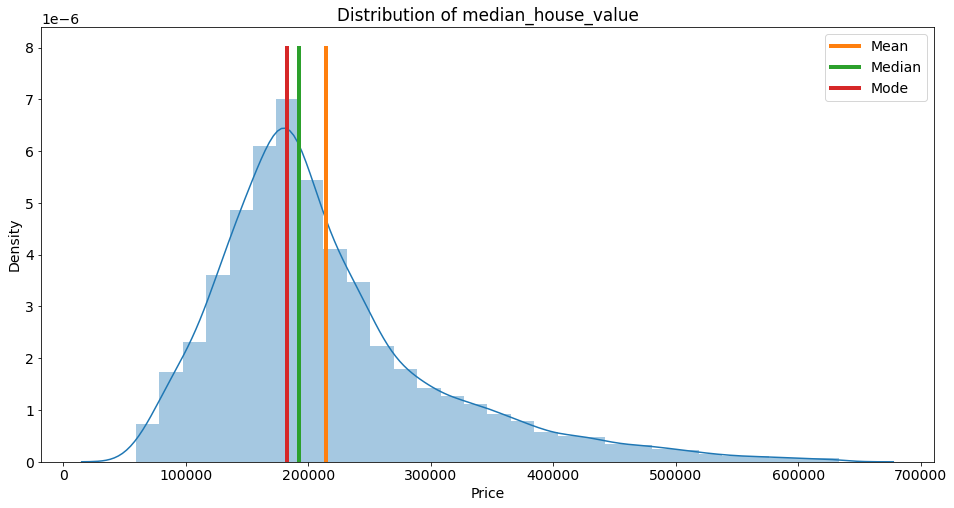

In [18]:
plt.figure(figsize = (16, 8))

sns.distplot(df_train['Price'],bins=30)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='Mean',  linewidth=4)
plt.plot([target_median] * 10, y, label='Median',  linewidth=4)
plt.plot([target_mode] * 10, y, label='Mode', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

*Выбросов не наблюдается, все в пределах нормы*

In [19]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


### Анализ количественных признаков

In [20]:
# Выбираем количественные признаки
df_num_features = df_train.loc[:, ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
                          'Floor', 'HouseFloor', 'HouseYear']]
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear
0,3.0,115.027313,NaN,10.0,4,10.0,2014
1,1.0,39.832523,23.169222,8.0,7,8.0,1966
2,3.0,78.342216,47.671970,10.0,2,17.0,1988
3,1.0,40.409908,NaN,1.0,10,22.0,1977
4,2.0,64.285065,38.562515,9.0,16,16.0,1972
...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969


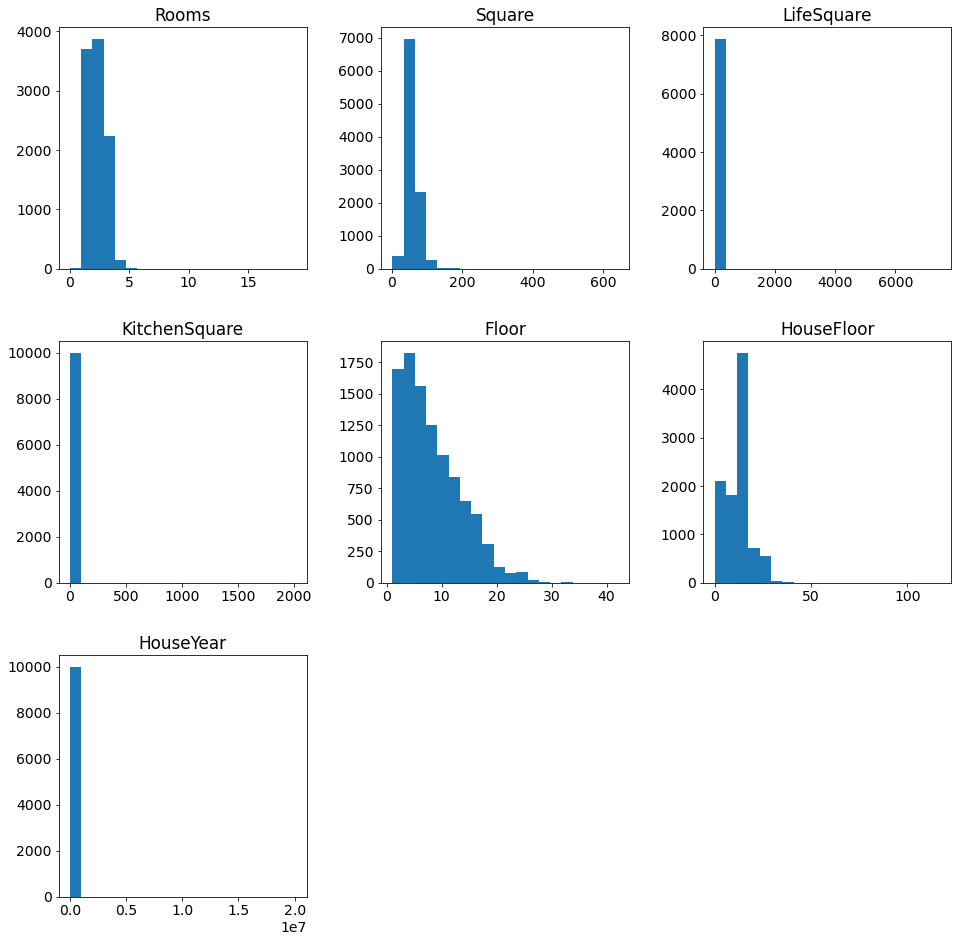

In [21]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

**Видны выбросы в следующих признаках:**
1. Rooms - слишком малое число слишком многокомнатных квартир(10 комнат - уже слишком)
2. Square - многовато 600 кв.м.
3. LifeSquare - тоже
4. KitchenSquare - тоже
5. Floor - данные на отшибе, подозрительно
6. HouseFloor - нет в Москве таких многоэтажек, в 100 этажей
7. HouseYear - 2*10^7, ни один динозавр не построил еще дом на своем веку

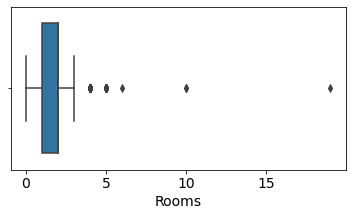

In [22]:
# Например, оценим выбросы с помощью boxplot
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Rooms'], whis=1.5)

plt.xlabel('Rooms')
plt.show()

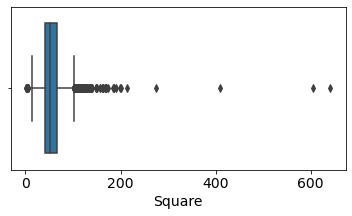

In [23]:
plt.figure(figsize=(6, 3))

sns.boxplot(df_train['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

*Жесточайшие выбросы, будем исправлять*

### Номининативные переменные

In [24]:
# Выведем категориальные переменные
df_train.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

*Посмотрим частоту появления каждой условной категории для этих признаков*

In [25]:
df_train['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
174      1
117      1
209      1
199      1
Name: DistrictId, Length: 205, dtype: int64

In [26]:
df_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [27]:
df_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [28]:
df_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

**Оценим матрицу корреляций**

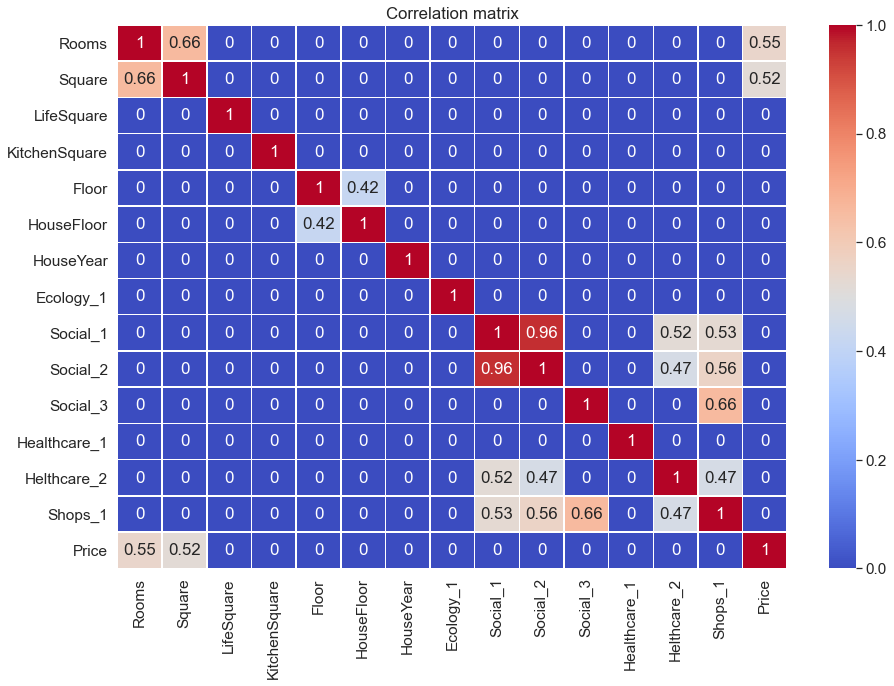

In [29]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

*Наблюдается странная корреляция между Social_1 и Social_2, неизвестно к чему это. Остальное в пределах логики*

### Обработка выбросов

**Рассмотрим более пристально каждый из признаков с выбросами**

***Rooms***

df_train['Rooms'].value_counts()

*Видим подозрительные данные в виде большого количества комнат и 0*

#Введем признак-маркер 
df_train['Rooms_outlier'] = 0
df_train.loc[(df_train['Rooms'] == 0) | (df_train['Rooms'] >= 6), 'Rooms_outlier'] = 1
df_train.head()

df_train['Rooms'].median()

#Заменим нулевые и большие значения на медиану,
#так как этот признак можно считать категориальным
df_train.loc[(df_train['Rooms'] >= 6)|(df_train['Rooms'] == 0), 'Rooms'] = df_train['Rooms'].median()

df_train['Rooms'].value_counts()

***KitchenSquare***

df_train['KitchenSquare'].value_counts()

df_train.isna()

*Есть как и очень большие-неадекватные, так и нулевые и очень маленькие значения*

*Будем решать данную проблему при помощи квантилей*


df_train['KitchenSquare'].quantile(.975), df_train['KitchenSquare'].quantile(.025)

#Видим, что даже квантиль четверти неадекватна, поэтому введем собственный критерий
#Заменяем нулевые и значения с разительным отклонением на медиану
df_train.loc[(df_train['KitchenSquare'].isna()) \
| (df_train['KitchenSquare'] > df_train['KitchenSquare'].quantile(.975)), 'KitchenSquare'] = df_train['KitchenSquare'].median()
df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3

df_train['KitchenSquare'].value_counts()

***HouseFloor, Floor***

*Найдем неадекватности, типа проживания в "облачном замке" и "земляных домиков". а также очень высокие дома*

*Найдем очень высокие дома, выше 50-го этажа*

df_train.loc[df_train['HouseFloor']>50, 'HouseFloor'].value_counts()

#Заменим их на квантили 97.5%
print(f"Квантиль 97.5%: {df_train['HouseFloor'].quantile(.975)}")
df_train.loc[df_train['HouseFloor']>50, 'HouseFloor'] = df_train['HouseFloor'].quantile(.975)
print(f"Суету навели удачно - {df_train.loc[df_train['HouseFloor']>50, 'HouseFloor'].sum() == 0}")

df_train['HouseFloor'].sort_values().unique()

df_train['HouseFloor'].value_counts()

Видим приличное количество "земляных домиков" и один небоскреб

df_train['Floor'].sort_values().unique()

#Выведем число очевидных несовпадений по принадлежности квартиры дому
len(df_train.loc[(df_train['HouseFloor'] == 0)|(df_train['Floor'] > df_train['HouseFloor']), 'Id'])

#Создадим маркер таких случаев
df_train['HouseFloor_outlier'] = 0
df_train.loc[(df_train['HouseFloor'] == 0)|(df_train['Floor'] > df_train['HouseFloor']), 'HouseFloor_outlier'] = 1
#Посмотрим, как правильно мы расставили флаги
df_train['HouseFloor_outlier'].value_counts()

#Заменим дома-землянки на одноэтажные дома 
df_train.loc[df_train['HouseFloor'] == 0, ['Floor', 'HouseFloor']] = 1
df_train.loc[df_train['HouseFloor_outlier'] == 1, 'Floor']

#Заменим облачные замки на средний этаж по дому
df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'Floor'] = df_train['HouseFloor']//2

*Посмотрим, что из этих маневров вышло*

(df_train['Floor'] > df_train['HouseFloor']).sum()

len(df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'])

*Все сработало, продолжаем работу*

***HouseYear***

#Посмотрим, что не так с этим признаком
df_train['HouseYear'].sort_values(ascending=False)

#Первые 2 значения не могут быть действительными, заменим подобные им на моду
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = df_train['HouseYear'].mode()

df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'].sum()

df_train.loc[df_train['HouseYear'].isna() == True]

***Square, LifeSquare***

print(f"""Противоречивые данные, в которых жилая площадь больше общей 
площади квартиры - {len(df_train.loc[df_train['LifeSquare'] > df_train['Square']])} строки""")

*Заменим на произведение общей площади и среднего от жилой площади к общей*

#Вычисляем средниюю часть жилой площади от общей и делаем это коэффициентом
k = round((df_train.loc[df_train['LifeSquare'] < df_train['Square'], ['LifeSquare', 'Square']]['LifeSquare']/df_train.loc[df_train['LifeSquare'] < df_train['Square'], ['LifeSquare', 'Square']]['Square']).mean(), 3)
k

#Производим замену
df_train.loc[df_train['LifeSquare'] > df_train['Square'], 'LifeSquare'] = df_train['Square']*k
#Проверяем, вышло ли


print(f"""Противоречивые данные, в которых жилая площадь больше общей 
площади квартиры - {len(df_train.loc[df_train['LifeSquare'] > df_train['Square']])} строки""")

### Обработка пропусков

#Посмотрим количество пропусков для каждого признака
df_train.isna().sum()

*Пропуски присутствуют в 'LifeSquare', 'HouseFloor', 'Helthcare_1', по непонятным мне причинам и 'HouseYear'*

***LifeSquare***

#Замену осуществим как раньше
df_train.loc[df_train['LifeSquare'].isna() == True , 'LifeSquare'] = df_train['Square']*k
#Проверим
df_train['LifeSquare'].isna().sum()

df_train.columns

***HouseFloor***

#Заменим этаж дома на квантили 97.5%
df_train.loc[df_train['HouseFloor'].isna(), 'HouseFloor'] = df_train['HouseFloor'].quantile(.975)
#Проверим
df_train['HouseFloor'].isna().sum()

#Проверили, не затронуло ли это прошлых изменений
len(df_train.loc[df_train['Floor'] > df_train['HouseFloor'], 'Id'])

***Healthcare_1***

#Заменим признак на среднее
df_train.loc[df_train['Healthcare_1'].isna(), 'Healthcare_1'] = df_train['Healthcare_1'].mean()

***HouseYear***

#Пустое заменим на 2020
df_train.loc[df_train['HouseYear'].isna() == True, 'HouseYear'] = 2020

#Проверим окончательные изменения
df_train.isna().sum()

*Все пропуски устранены - замечательно*

### Создадим класс DataPreprocessing

In [30]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.kitchen_square_quantile = None
        self.k = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан и прочего
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        self.k = round((X.loc[X['LifeSquare'] < X['Square'], ['LifeSquare', 'Square']]['LifeSquare']/X.loc[X['LifeSquare'] < X['Square'], ['LifeSquare', 'Square']]['Square']).mean(), 3)

    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[(X['Rooms'] >= 6)|(X['Rooms'] == 0), 'Rooms'] = X['Rooms'].median()
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'].isna()) \
            | (X['KitchenSquare'] > self.kitchen_square_quantile), 'KitchenSquare'] = X['KitchenSquare'].median()
        df_train.loc[df_train['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier']= 1
        
        X.loc[(X['HouseFloor']>50)|(X['HouseFloor'].isna()), 'HouseFloor'] = X['HouseFloor'].quantile(.975)

        X.loc[X['HouseFloor'] == 0, ['Floor', 'HouseFloor']] = 1
        
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X['HouseFloor']//2
        
        # HouseYear
        # Умышленно оставим как в примере
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[(X['HouseYear'] > current_year)|(X['HouseYear'].isna() == True), 'HouseYear'] = current_year
        
        # Healthcare_1
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] = X['Healthcare_1'].mean()
        
        # LifeSquare
        X.loc[(X['LifeSquare'] > X['Square'])|(X['LifeSquare'].isna() == True), 'LifeSquare'] = X['Square']*self.k

        
        return X

### Построение новых признаков

***Dummies***

#Заменяем буковки на чиселки
binary_to_numbers = {'A': 0, 'B': 1}

df_train['Ecology_2'] = df_train['Ecology_2'].replace(binary_to_numbers)
df_train['Ecology_3'] = df_train['Ecology_3'].replace(binary_to_numbers)
df_train['Shops_2'] = df_train['Shops_2'].replace(binary_to_numbers)

***DistrictSize, IsDistrictLarge***

#Для каждого райна подсчитываем количество встречаемости и кодируем этим чиселком сам район
district_size = df_train['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

#Добавляем принак с его столбцами в исходную таблицу по признаку DistrictId
df_train = df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

#Подсчитываем количество условно популярных райнов
(df_train['DistrictSize'] > 100).value_counts()

#Вводим новый признак популярности(величины) района
df_train['IsDistrictLarge'] = (df_train['DistrictSize'] > 100).astype(int)

***MedPriceByDistrict***

#Вводим новый признак, учитывающий связь между ценой, райном и количеством комнат
med_price_by_district = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

med_price_by_district.shape

#Добавляем этот признак
df_train = df_train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
df_train.head()

***MedPriceByFloorYear***

def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X

def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

#Создаем 2 новых признака - класс этажа и класс года
df_train = year_to_cat_pandas(df_train)
df_train = floor_to_cat_pandas(df_train)
df_train.head()

#Создаем новый признак учитывающий зависимости между годом постройки, этажом и ценой
med_price_by_floor_year = df_train.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

#Добавляем признак в исходную таблицу
df_train = df_train.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
df_train.head()

***Создадим новый класс FeatureGenerator, обобщающий все прошлые махинации***

In [31]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
            
    

### Отбор признаков

In [32]:
#Разбиваем наши признаки на 3 категории: дано, добавили, целевой
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',  'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### Разбиение на train и test

In [33]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

X = df_train.drop(columns=target_name)
y = df_train[target_name]

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [35]:
#Совершаем разного рода предварительные манипуляции
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
df_test = preprocessor.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 22), (3300, 22), (5000, 22))

In [36]:
#Генерируем новые признаки
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
df_test = features_gen.transform(df_test)

X_train.shape, X_valid.shape, df_test.shape

((6700, 29), (3300, 29), (5000, 29))

In [37]:
#Объединяем принаковые таблицы
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
df_test = df_test[feature_names + new_feature_names]

In [38]:
#Пропусков нет
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

### Построение модели

***Кросс-валидация***

***Оценим важность признаков***

Train R2:	0.901
Test R2:	0.725


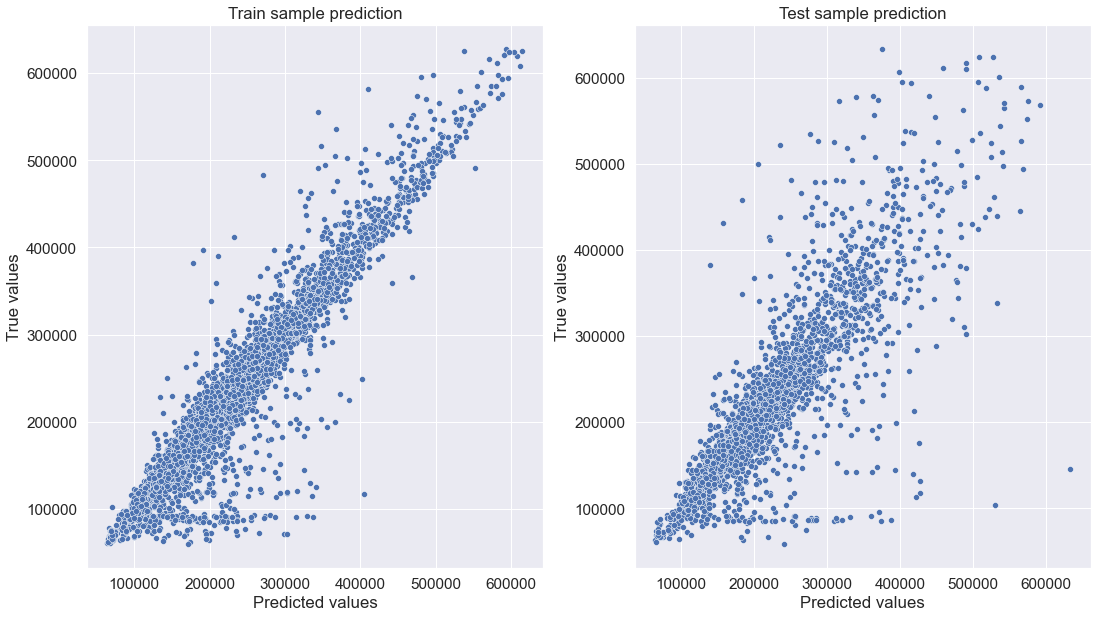

In [39]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=6,
                                     min_samples_leaf=11,
                                     random_state=24,
                                     max_features=0.5, 
                                     loss='huber', 
                                     learning_rate=0.025,
                                     n_estimators=1000)

gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

***Кросс-валидация***

In [40]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.79128298, 0.75106506, 0.77499002])

In [41]:
cv_score.mean()

0.7724460191867161

***Оцениваем важность признаков***

In [42]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
22,MedPriceByDistrict,4.957897e-01
1,Square,1.707883e-01
2,LifeSquare,5.398439e-02
19,DistrictSize,5.228163e-02
0,Rooms,4.595776e-02
11,Social_2,2.544424e-02
10,Social_1,2.166822e-02
23,MedPriceByFloorYear,2.131612e-02
12,Social_3,1.807678e-02
3,KitchenSquare,1.763184e-02


### Прогнозируем на тестовых значениях

In [43]:
df_test.shape

(5000, 24)

In [44]:
df_test

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,DistrictSize,new_district,IsDistrictLarge,MedPriceByDistrict,MedPriceByFloorYear
0,1.0,36.847630,19.094182,5.0,5.0,9.0,1970,0.036122,1,1,...,1,1,0,0,0,76.0,0,0,171145.169069,190440.131430
1,1.0,42.493907,26.473704,10.0,7.0,17.0,2017,0.072158,1,1,...,0,0,0,0,0,164.0,0,1,131107.271962,175771.383549
2,2.0,59.463678,37.045872,9.0,19.0,19.0,1977,0.211401,1,1,...,1,1,0,0,0,580.0,0,1,166353.734353,171931.149112
3,3.0,49.646030,33.893825,6.0,2.0,2.0,1965,0.014073,1,1,...,0,1,0,0,0,372.0,0,1,172778.615365,178919.076780
4,1.0,53.837056,33.540486,1.0,8.0,17.0,1977,0.309479,1,1,...,6,1,0,0,0,65.0,0,0,164116.183543,192711.526271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,2.0,5.0,1962,0.069660,1,1,...,2,1,0,1,0,56.0,0,0,183575.963167,178919.076780
4996,3.0,93.698122,58.373930,10.0,21.0,27.0,2018,0.060753,1,1,...,7,1,0,0,0,26.0,0,0,425037.641820,192903.132839
4997,1.0,33.656723,19.003259,5.0,2.0,5.0,1966,0.038693,1,1,...,5,1,0,0,0,54.0,0,0,156266.487610,178919.076780
4998,1.0,38.635155,20.976257,9.0,8.0,14.0,1970,0.089040,1,1,...,11,1,0,0,0,40.0,0,0,185704.766694,192711.526271


In [45]:
submit = pd.read_csv('Data/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


***Строим предсказание***

In [46]:
predictions = gb_model.predict(df_test)
predictions

array([172721.2260611 , 123868.29840918, 136109.78833017, ...,
       148764.24316488, 188691.73425662, 253807.57412987])

In [47]:
# Заносим полученные предсказания в файл
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,172721.226061
1,5925,123868.298409
2,960,136109.788330
3,3848,126592.157350
4,746,197865.993125


In [48]:
# Сохраняем файл как rf_submit.csv
submit.to_csv('rf_submit.csv', index=False)